# This notebook aims to show the labeling a time series process

In [1]:
import os, sys, pandas as pd, matplotlib.pyplot as plt, plotly.offline as py, json

import matplotlib.pyplot as plt, plotly.express as px, webbrowser, json, pandas as pd, os

from dash import Dash, dcc, html, Input, Output

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import manual_labeler_functions as man_lab_fun, general_functions as gf, files_paths as fp

## Analyzes the graphs of the selected video series

In [2]:
def PLOT_MEASURE_EXPLORER(df):

    port = 5000
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
    app = Dash(__name__, external_stylesheets=external_stylesheets)

    def open_browser():
    	webbrowser.open_new("http://localhost:{}".format(port))
          
    app.layout = html.Div([
        html.H4('Measure Explorer'),
        html.H6('Reference Signal'),
        html.I('Setting the frame interval range'),
        html.Br(),
        dcc.Input(id='input-init', type='number', min=df.index.min(), max=df.index.max(), value=df.index.min()),
        dcc.Input(id='input-end', type='number', value=df.index.max()),
        dcc.Graph(id="graph"),
        dcc.Checklist(
            id="checklist",
            options=df.columns,
            value=["m1", "m3"],
            inline=True
        ),
        dcc.Store(
        id='data-output',
        data=[{
            'measures': ["m1", "m3"],
            'init_label': df.index.min(),
            'end_label': df.index.max()
        }]
        ),
        html.Br(),
        html.Details([
        html.Summary('Input Parameters'),
        dcc.Markdown(id='clientside-figure-json')
        ])
    ])
    
    @app.callback(
        Output("graph", "figure"), 
        Input("checklist", "value"),
        Input("input-init", "value"),
        Input("input-end", "value"))
    def update_line_chart(measures, frame_init, frame_end):
        mask = df.columns.isin(measures)
        filtered_df = df.loc[frame_init:frame_end, mask]
        fig = px.line(filtered_df, width=900, height=400, labels={
                     "frame_seq": "<b>Frame number</b>",
                     "value": "<b>Amplitude (pixels)</b>",
                     "variable": "<b>Measures</b>"
                 },)
        data = measures
        fig.update_layout(
            plot_bgcolor='white',
            font_size=12,
        )
        fig.update_xaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            gridcolor='lightgrey',
        )
        fig.update_yaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            gridcolor='lightgrey',
        )
        return fig

    @app.callback(
        Output('data-output', 'data'),
        Input("checklist", "value"),
        Input("input-init", "value"),
        Input("input-end", "value"))
    def update_store_data(measures, frame_init, frame_end):
        mask = df.columns.isin(measures)
        filtered_df = df.loc[:,mask]
        return [{
            'measures': filtered_df.columns,
            'init_label': frame_init,
            'end_label': frame_end
        }]
    
    
    @app.callback(
        Output('clientside-figure-json', 'children'),
        Input('data-output', 'data')
    )
    def generated_data_json(data):
        return '```\n'+json.dumps(data, indent=2)+'\n```'
   
    if __name__ == '__main__':
        app.run_server(debug=True, port=port)

In [3]:
# Function to plot a graph with markers for the classes
def PLOT_CLASS_GRAPH(VD_LABELED_DT, VD_MEASURE_DT_V2, class_in, start_frame=None, end_frame=None):
    fonte = {'color': 'black', 'weight': 'bold', 'size': 10}
    
    get_measur = man_lab_fun.GET_MEASURES_FROM_CLASS (VD_LABELED_DT, class_in)
    frames_f_class = man_lab_fun.GET_FRAMES_FROM_CLASS(VD_LABELED_DT, class_in)
    frames_f_class= man_lab_fun.separate_intervals(frames_f_class)
    PLOT_DT = VD_MEASURE_DT_V2[get_measur].copy()

    if start_frame is not None and end_frame is not None:
        PLOT_DT = PLOT_DT[start_frame:end_frame+1]
        
    # Plot graph
    fig, ax = plt.subplots(figsize=(9, 3))
    
    ax.plot(PLOT_DT.index, PLOT_DT, label=get_measur)
    
    for interval in frames_f_class:
        ax.fill_between(interval, 0, 1, alpha=0.2, transform=ax.get_xaxis_transform(), label=f'{class_in}: {interval}')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Amplitude (pixel)', fontdict=fonte)
    plt.xlabel('Frame number', fontdict=fonte)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('graph.png')
    plt.show()

## Getting all the CSV files in the REF-Gold-Label

In [4]:
FILE_LIST_VD_MEASURE = gf.find_files_in_all_subdirectories([fp.DATASET_SEED],'*' + ".CSV")

## Generates an index with information about reference series.

In [5]:
INDEX_DT = man_lab_fun.CREATE_LABELED_INDEX(FILE_LIST_VD_MEASURE)

## Selects the video for analysis and CSV data file

In [6]:
# Type the video id to label
VIDEO_ID = 3

VIDEO_FILE_PATH = str(INDEX_DT.loc[VIDEO_ID,'path']).split()[2]

# Read CSV data file
VD_MEASURE_DT = man_lab_fun.READ_CSV_FILE(VIDEO_FILE_PATH, fp.VD_MEASURE_L0)

# set frames_seq as index
VD_MEASURE_DT_V2 = VD_MEASURE_DT.set_index(pd.Index(VD_MEASURE_DT['frame_seq']))
VD_MEASURE_DT_V2.drop(columns=["frame_seq"], inplace=True)

In [7]:
PLOT_MEASURE_EXPLORER(VD_MEASURE_DT_V2)

## Loads frames from the selected video for further image analysis 


In [8]:
VIDEO_EXT = '.mp4'

# Get path from selected video id
video_id = str(INDEX_DT.loc[VIDEO_ID,'link_video']).split()[2] + VIDEO_EXT
path_video_file = os.path.join(fp.VIDEO_SOURCE_SEED, video_id)

video_frames = man_lab_fun.LOAD_VIDEO_FRAMES(path_video_file)

Error opening video


## Displays frames for image analysis

In [9]:
start_frame_crop = 14
end_frame_crop = 17
n_frames_per_row = 6
man_lab_fun.DISPLAY_FRAMES(video_frames, start_frame_crop, end_frame_crop, n_frames_per_row)

<Figure size 1500x200 with 0 Axes>

## Reads or creates the VD_LABELED file if it does not exist.

In [10]:
labeled_file_exists = int(str(INDEX_DT.loc[VIDEO_ID,'label_file_exist']).split()[2])

if labeled_file_exists == 0:
    print('Creating Label File...')
    VD_MEASURE_DT['label_measures'] = str({})
    VD_LABELED_DT = VD_MEASURE_DT.copy()
else:
    print('Reading Label File...') 
    VD_LABELED_DT = man_lab_fun.READ_CSV_FILE(str(INDEX_DT.loc[VIDEO_ID,'path']).split()[2], fp.VD_LABELED_L0)

Reading Label File...


## Label the selected frames

In [11]:
# Type the Begin and End frames you want to label
init_frame_label = 0
end_frame_label = 19

# Prepare List and Dict
selected_class = 'anger'
label_measure_insert = ["e1", "e2", "b1", "b2", "b3", "m6", "m7", "m14", "m17"]

# Just Insert
VD_LABELED_DT = man_lab_fun.UPDATE_LABEL_DF(init_frame_label, end_frame_label, selected_class, label_measure_insert, VD_LABELED_DT)

## Verify the added labels.

In [12]:
try:
    get_measure = man_lab_fun.GET_MEASURES_FROM_CLASS (VD_LABELED_DT, selected_class)
    print(get_measure)
except:
    print('Class not found')

['e1', 'e2', 'b1', 'b2', 'b3', 'm6', 'm7', 'm14', 'm17']


## Plots a graph marking the start and end of the labels for a class.

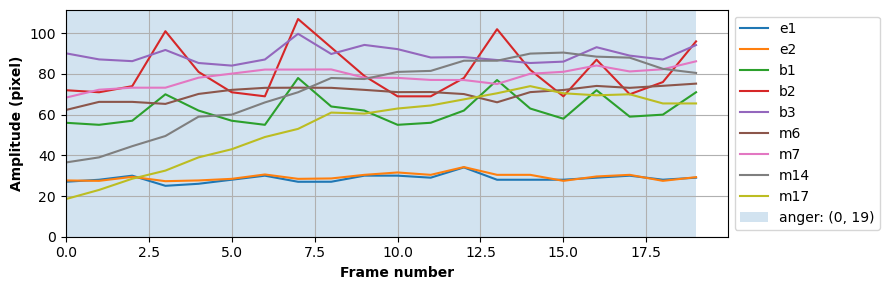

In [13]:
# Select the begin and end frame to be shown
start_frame = 0
end_frame = len(VD_LABELED_DT)

py.init_notebook_mode(connected=True)
plt.rcParams['font.size'] = 10

PLOT_CLASS_GRAPH(VD_LABELED_DT, VD_MEASURE_DT_V2, selected_class, start_frame, end_frame)

## Save the VD_LABELED file to disk

In [14]:
VD_LABELED_DT.to_csv(os.path.join(VIDEO_FILE_PATH, fp.VD_LABELED_L0))